In [10]:
import geopandas as gpd
from shapely.geometry import box
import numpy as np

# Load the shapefile
shapefile_path = "h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\north.shp"
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the polygon (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = gdf.total_bounds

# Grid parameters
grid_width = 100  # width of the grid in meters
grid_height = 100  # height of the grid in meters

# Base the grid on the southernmost and easternmost coordinates
eastest = maxx
southest = miny

# Generate grid cells
grid_cells = []
x_right = eastest
while x_right > minx:
    y_bottom = southest
    while y_bottom < maxy:
        # Create a 100x100 meter box
        cell = box(x_right - grid_width, y_bottom, x_right, y_bottom + grid_height)
        grid_cells.append(cell)
        y_bottom += grid_height
    x_right -= grid_width

# Create a GeoDataFrame with the grid cells
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)

# Save the grid as a new shapefile
grid_gdf.to_file("h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\north_grid.shp")

print("Grid shapefile created and saved as 'grid_100x100.shp'")


Grid shapefile created and saved as 'grid_100x100.shp'


In [1]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# Define the paths
tiff_file = 'h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF7Band.tif'
grid_shapefile = "h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\north_grid.shp"  # Use the grid shapefile created earlier
output_shapefile = 'h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered3.shp'

# Load the grid shapefile
grid_gdf = gpd.read_file(grid_shapefile)

# Open the TIFF image
with rasterio.open(tiff_file) as src:
    # Get metadata and calculate tile size in pixels
    meta = src.meta
    pixel_size = src.res[0]  # Assumes square pixels

    # Get the bounds of the TIFF file
    tiff_bounds = src.bounds

    # Prepare to store grid geometries and attributes
    grid_data = []

    # Loop through each polygon in the grid
    for index, row in grid_gdf.iterrows():
        # Check if the grid cell intersects with the TIFF file bounds
        if not row.geometry.intersects(box(*tiff_bounds)):
            continue  # Skip this grid cell if it doesn't intersect with the TIFF bounds

        # Calculate the intersection of the grid cell with the TIFF bounds
        intersection = row.geometry.intersection(box(*tiff_bounds))

        # Calculate the bounds of the intersection in pixel coordinates
        min_x, min_y, max_x, max_y = intersection.bounds
        min_row, min_col = src.index(min_x, min_y)
        max_row, max_col = src.index(max_x, max_y)

        # Define the window to read the tile
        window = rasterio.windows.Window.from_slices(
            (min_row, max_row),
            (min_col, max_col)
        )

        # Read the last four bands (infrared, red-edge, red, green)
        tile = src.read((4, 5, 6, 7), window=window)
        
        # Check if there are any pixels with value 0 or NaN
        # if np.any(tile == 0) or np.any(np.isnan(tile)):
        #     continue  # Skip this tile if condition is met

        # Calculate squared deviations
        squared_deviation = (tile - tile.mean(axis=(1, 2), keepdims=True))**2
        
        # Calculate the sum of squares for each band
        sum_of_squares = np.sum(squared_deviation, axis=(1, 2))
        
        # Divide the sum by the number of pixels to get mean squared deviation
        mean_squared_deviation = sum_of_squares / (tile.shape[1] * tile.shape[2])
        
        # Calculate the total sum of squares across all bands
        total_sum_of_squares = np.sum(mean_squared_deviation)
        
        # Calculate FCSD (each band's mean squared deviation divided by total sum of squares)
        fcsd = mean_squared_deviation / total_sum_of_squares
        
        # Append the grid cell's data to the list
        grid_data.append({
            'geometry': intersection,
            'mean_squared_deviation_ir': mean_squared_deviation[0],
            'mean_squared_deviation_red_edge': mean_squared_deviation[1],
            'mean_squared_deviation_red': mean_squared_deviation[2],
            'mean_squared_deviation_green': mean_squared_deviation[3],
            'total_sum_of_squares': total_sum_of_squares,
            'fcsd_ir': fcsd[0],
            'fcsd_red_edge': fcsd[1],
            'fcsd_red': fcsd[2],
            'fcsd_green': fcsd[3]
        })

# Convert the list to a GeoDataFrame
result_gdf = gpd.GeoDataFrame(grid_data, crs=grid_gdf.crs)

# Save the results as a new shapefile
result_gdf.to_file(output_shapefile)

print(f"Grid shapefile with calculations saved as '{output_shapefile}'")


C:\Users\user\AppData\Local\Temp\ipykernel_13132\2615077016.py:54: RuntimeWarning: Mean of empty slice.
  squared_deviation = (tile - tile.mean(axis=(1, 2), keepdims=True))**2
c:\Users\user\.conda\envs\RS\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\user\AppData\Local\Temp\ipykernel_13132\2615077016.py:60: RuntimeWarning: invalid value encountered in divide
  mean_squared_deviation = sum_of_squares / (tile.shape[1] * tile.shape[2])
C:\Users\user\AppData\Local\Temp\ipykernel_13132\2615077016.py:86: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_gdf.to_file(output_shapefile)


Grid shapefile with calculations saved as 'h:\Yehmh\DNDF\202404_DNDF\spectral_diversity\alpha_diversity_filtered3.shp'


In [3]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from rasterio.mask import mask

# Define the paths
tiff_file = 'h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF7Band.tif'
grid_shapefile = "h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\north_grid.shp"
output_shapefile = 'h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered3.shp'

# Load the grid shapefile
grid_gdf = gpd.read_file(grid_shapefile)

# Open the TIFF image
with rasterio.open(tiff_file) as src:
    # Get metadata and calculate tile size in pixels
    meta = src.meta
    pixel_size = src.res[0]

    # Get the bounds of the TIFF file
    tiff_bounds = src.bounds

    # Prepare to store grid geometries and attributes
    grid_data = []

    # Loop through each polygon in the grid
    for index, row in grid_gdf.iterrows():
        # Check if the grid cell intersects with the TIFF file bounds
        if not row.geometry.intersects(box(*tiff_bounds)):
            continue

        # Calculate the intersection of the grid cell with the TIFF bounds
        intersection = row.geometry.intersection(box(*tiff_bounds))

        # Calculate the bounds of the intersection in pixel coordinates
        min_x, min_y, max_x, max_y = intersection.bounds
        min_row, min_col = src.index(min_x, min_y)
        max_row, max_col = src.index(max_x, max_y)

        # Define the window to read the tile
        window = rasterio.windows.Window.from_slices(
            (min_row, max_row),
            (min_col, max_col)
        )

        # Read the last four bands (infrared, red-edge, red, green)
        tile = src.read((4, 5, 6, 7), window=window)
        
        # Create a mask for the grid cell
        mask_geom = [row.geometry]
        masked_tile, _ = mask(src, shapes=mask_geom, crop=True)

        # Calculate squared deviations
        squared_deviation = (masked_tile - masked_tile.mean(axis=(1, 2), keepdims=True))**2
        
        # Calculate the sum of squares for each band
        sum_of_squares = np.sum(squared_deviation, axis=(1, 2))
        
        # Divide the sum by the number of pixels to get mean squared deviation
        mean_squared_deviation = sum_of_squares / np.sum(masked_tile > 0, axis=(1, 2))
        
        # Calculate the total sum of squares across all bands
        total_sum_of_squares = np.sum(mean_squared_deviation)
        
        # Calculate FCSD (each band's mean squared deviation divided by total sum of squares)
        fcsd = mean_squared_deviation / total_sum_of_squares
        
        # Append the grid cell's data to the list
        grid_data.append({
            'geometry': intersection,
            'mean_squared_deviation_ir': mean_squared_deviation[0],
            'mean_squared_deviation_red_edge': mean_squared_deviation[1],
            'mean_squared_deviation_red': mean_squared_deviation[2],
            'mean_squared_deviation_green': mean_squared_deviation[3],
            'total_sum_of_squares': total_sum_of_squares,
            'fcsd_ir': fcsd[0],
            'fcsd_red_edge': fcsd[1],
            'fcsd_red': fcsd[2],
            'fcsd_green': fcsd[3]
        })

# Convert the list to a GeoDataFrame
result_gdf = gpd.GeoDataFrame(grid_data, crs=grid_gdf.crs)

# Save the results as a new shapefile
result_gdf.to_file(output_shapefile)

print(f"Grid shapefile with calculations saved as '{output_shapefile}'")


C:\Users\user\AppData\Local\Temp\ipykernel_13132\992628565.py:61: RuntimeWarning: invalid value encountered in divide
  mean_squared_deviation = sum_of_squares / np.sum(masked_tile > 0, axis=(1, 2))
C:\Users\user\AppData\Local\Temp\ipykernel_13132\992628565.py:61: RuntimeWarning: invalid value encountered in divide
  mean_squared_deviation = sum_of_squares / np.sum(masked_tile > 0, axis=(1, 2))
C:\Users\user\AppData\Local\Temp\ipykernel_13132\992628565.py:61: RuntimeWarning: invalid value encountered in divide
  mean_squared_deviation = sum_of_squares / np.sum(masked_tile > 0, axis=(1, 2))
C:\Users\user\AppData\Local\Temp\ipykernel_13132\992628565.py:61: RuntimeWarning: invalid value encountered in divide
  mean_squared_deviation = sum_of_squares / np.sum(masked_tile > 0, axis=(1, 2))
C:\Users\user\AppData\Local\Temp\ipykernel_13132\992628565.py:61: RuntimeWarning: invalid value encountered in divide
  mean_squared_deviation = sum_of_squares / np.sum(masked_tile > 0, axis=(1, 2))
C:\Us

Grid shapefile with calculations saved as 'h:\Yehmh\DNDF\202404_DNDF\spectral_diversity\alpha_diversity_filtered3.shp'


In [2]:
import geopandas as gpd

# Read the shapefile
gdf = gpd.read_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered3.shp')

# Print the first few rows of the GeoDataFrame
print(gdf.head())

  mean_squar mean_squ_1 mean_squ_2 mean_squ_3 total_sum_ fcsd_ir fcsd_red_e  \
0       None       None       None       None       None    None       None   
1       None       None       None       None       None    None       None   
2       None       None       None       None       None    None       None   
3       None       None       None       None       None    None       None   
4       None       None       None       None       None    None       None   

  fcsd_red fcsd_green                                           geometry  
0     None       None  POLYGON ((293487.577 2612030.218, 293587.577 2...  
1     None       None  POLYGON ((293487.577 2612030.218, 293487.577 2...  
2     None       None  POLYGON ((293487.577 2612130.218, 293487.577 2...  
3     None       None  POLYGON ((293487.577 2612230.218, 293487.577 2...  
4     None       None  POLYGON ((293487.577 2612330.218, 293487.577 2...  


In [15]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from shapely.geometry import box, shape
from shapely.geometry import mapping
import pandas as pd

# Paths to files
shapefile_path = "h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\north_grid.shp"
tiff_file_path = 'h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF7Band.tif'
output_shapefile_path = 'h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered4.shp'

# Load the shapefile
shapefile = gpd.read_file(shapefile_path)

# Open the TIFF file
with rasterio.open(tiff_file_path) as src:
    bands = [4, 5, 6, 7]  # Last four bands
    band_data = [src.read(band) for band in bands]
    metadata = src.meta
    crs = src.crs

    # Get TIFF bounds
    tiff_bounds = box(*src.bounds)

# Initialize list for grid data
grid_data = []

# Iterate through Grid Polygons
for _, row in shapefile.iterrows():
    geom = row['geometry']
    
    # Create a mask for the tile
    with rasterio.open(tiff_file_path) as src:
        out_image, out_transform = mask(src, [geom], crop=True)
        
        if out_image.shape[1] > 0 and out_image.shape[2] > 0:
            tile_bounds = box(*src.xy(out_transform[3], out_transform[0]))
            if tile_bounds.intersects(tiff_bounds):
                # Perform the calculations
                tile = np.stack([out_image[i] for i in range(len(out_image))], axis=0)

                # Calculate squared deviations
                squared_deviation = (tile - tile.mean(axis=(1, 2), keepdims=True))**2

                # Calculate the sum of squares for each band
                sum_of_squares = np.sum(squared_deviation, axis=(1, 2))

                # Divide the sum by the number of pixels to get mean squared deviation
                mean_squared_deviation = sum_of_squares / (tile.shape[1] * tile.shape[2])

                # Calculate the total sum of squares across all bands
                total_sum_of_squares = np.sum(mean_squared_deviation)

                # Calculate FCSD (each band's mean squared deviation divided by total sum of squares)
                fcsd = mean_squared_deviation / total_sum_of_squares

                # Append the grid cell's data to the list
                grid_data.append({
                    'geometry': mapping(geom),
                    'mean_squared_deviation_ir': mean_squared_deviation[0],
                    'mean_squared_deviation_red_edge': mean_squared_deviation[1],
                    'mean_squared_deviation_red': mean_squared_deviation[2],
                    'mean_squared_deviation_green': mean_squared_deviation[3],
                    'total_sum_of_squares': total_sum_of_squares,
                    'fcsd_ir': fcsd[0],
                    'fcsd_red_edge': fcsd[1],
                    'fcsd_red': fcsd[2],
                    'fcsd_green': fcsd[3]
                })

# Create a GeoDataFrame with the calculated data
grid_gdf = gpd.GeoDataFrame(grid_data, geometry='geometry', crs=crs)

# Save the results to a new shapefile
grid_gdf.to_file(output_shapefile_path)

print(f"Results saved to {output_shapefile_path}")


In [7]:
import rasterio

tiff_file = 'h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF7Band.tif'

# Open the TIFF image
with rasterio.open(tiff_file) as src:
    # Get metadata and calculate tile size in pixels
    meta = src.meta
    pixel_size = src.res[0]  # Assumes square pixels
    tile_size = 100  # Tile size in meters
    tile_size_pixels = int(tile_size / pixel_size)
    
    print(pixel_size, tile_size_pixels, pixel_size*tile_size_pixels)
    print(src.crs)

0.057756557219199124 1731 99.97660054643369
EPSG:3826


In [2]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# Define the TIFF file path
tiff_file = 'h:\\Yehmh\\DNDF\\202404_DNDF\\DNDF7Band.tif'

# Open the TIFF image
with rasterio.open(tiff_file) as src:
    # Get metadata and calculate tile size in pixels
    meta = src.meta
    pixel_size = src.res[0]  # Assumes square pixels
    tile_size = 100  # Tile size in meters
    tile_size_pixels = int(tile_size / pixel_size)
    
    # Calculate the number of rows and columns for the grid
    rows = src.height // tile_size_pixels
    cols = src.width // tile_size_pixels
    
    # Prepare to store grid geometries and attributes
    grid = []

    # Loop through each tile in the grid
    for row in range(rows):
        for col in range(cols):
            # Define the window to read the tile
            window = rasterio.windows.Window(
                col * tile_size_pixels, row * tile_size_pixels, 
                tile_size_pixels, tile_size_pixels
            )

            # Read the last four bands (red, green, infrared, red-edge)
            tile = src.read((4, 5, 6, 7), window=window)
            
            # # Check if there are any pixels with value 0 or NaN
            # if np.any(tile == 0) or np.any(np.isnan(tile)):
            #     continue  # Skip this tile if condition is met

            # Calculate the proportion of pixels with value 0 or NaN
            zero_or_nan_ratio = np.mean((tile == 0) | np.isnan(tile), axis=(1, 2))

            # Skip the tile if more than 95% of the pixels are 0 or NaN in any band
            if np.any(zero_or_nan_ratio > 0.05):
                continue

            # Calculate squared deviations
            squared_deviation = (tile - tile.mean(axis=(1, 2), keepdims=True))**2
            
            # Calculate the sum of squares for each band
            sum_of_squares = np.sum(squared_deviation, axis=(1, 2))
            
            # Divide the sum by the number of pixels to get mean squared deviation
            mean_squared_deviation = sum_of_squares / (tile_size_pixels**2)
            
            # Calculate the total sum of squares across all bands
            total_sum_of_squares = np.sum(mean_squared_deviation)
            
            # Calculate FCSD (each band's mean squared deviation divided by total sum of squares)
            fcsd = mean_squared_deviation / total_sum_of_squares

            # Calculate NDVI using infrared (band 6) and red (band 4)
            nir = tile[2]  # Infrared band (band 6)
            red = tile[0]  # Red band (band 4)
            ndvi = (nir - red) / (nir + red)
            mean_ndvi = np.mean(ndvi)
            
            # Calculate the coordinates of the grid cell
            min_x, min_y = src.xy(row * tile_size_pixels, col * tile_size_pixels)
            max_x, max_y = src.xy((row + 1) * tile_size_pixels, (col + 1) * tile_size_pixels)
            
            # Create a polygon for the grid cell
            polygon = box(min_x, max_y, max_x, min_y)
            
            # Append the grid cell's data to the list
            grid.append({
                'geometry': polygon,
                'row': row,
                'col': col,
                'mean_squared_deviation_ir': mean_squared_deviation[0],
                'mean_squared_deviation_red_edge': mean_squared_deviation[1],
                'mean_squared_deviation_red': mean_squared_deviation[2],
                'mean_squared_deviation_green': mean_squared_deviation[3],
                'total_sum_of_squares': total_sum_of_squares,
                'fcsd_ir': fcsd[0],
                'fcsd_red_edge': fcsd[1],
                'fcsd_red': fcsd[2],
                'fcsd_green': fcsd[3],
                'mean_ndvi': mean_ndvi
            })

# Convert the list to a GeoDataFrame
gdf = gpd.GeoDataFrame(grid)

# Save the grid as a shapefile
gdf.to_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_100_100_ndvi.shp')


C:\Users\user\AppData\Local\Temp\ipykernel_11828\3942243118.py:65: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
C:\Users\user\AppData\Local\Temp\ipykernel_11828\3942243118.py:96: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_100_100_ndvi.shp')


In [12]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# Define the TIFF file path
tiff_file = 'h:\\Yehmh\\ZF\\202405\\merge_clip.tif'

# Open the TIFF image
with rasterio.open(tiff_file) as src:
    # Get metadata and calculate tile size in pixels
    meta = src.meta
    pixel_size = src.res[0]  # Assumes square pixels
    tile_size = 100  # Tile size in meters
    tile_size_pixels = int(tile_size / pixel_size)
    
    # Calculate the number of rows and columns for the grid
    rows = src.height // tile_size_pixels
    cols = src.width // tile_size_pixels
    
    # Prepare to store grid geometries and attributes
    grid = []

    # Loop through each tile in the grid
    for row in range(rows):
        for col in range(cols):
            # Define the window to read the tile
            window = rasterio.windows.Window(
                col * tile_size_pixels, row * tile_size_pixels, 
                tile_size_pixels, tile_size_pixels
            )

            # Read the last four bands (infrared, red-edge, red, green)
            tile = src.read((1, 2, 3, 4, 5), window=window)
            
            # # Check if there are any pixels with value 0 or NaN
            # if np.any(tile == 0) or np.any(np.isnan(tile)):
            #     continue  # Skip this tile if condition is met

            # Calculate the proportion of pixels with value 0 or NaN
            zero_or_nan_ratio = np.mean((tile == 0) | np.isnan(tile), axis=(1, 2))

            # Skip the tile if more than 95% of the pixels are 0 or NaN in any band
            if np.any(zero_or_nan_ratio > 0.05):
                continue


            # Calculate squared deviations
            squared_deviation = (tile - tile.mean(axis=(1, 2), keepdims=True))**2
            
            # Calculate the sum of squares for each band
            sum_of_squares = np.sum(squared_deviation, axis=(1, 2))
            
            # Divide the sum by the number of pixels to get mean squared deviation
            mean_squared_deviation = sum_of_squares / (tile_size_pixels**2)
            
            # Calculate the total sum of squares across all bands
            total_sum_of_squares = np.sum(mean_squared_deviation)
            
            # Calculate FCSD (each band's mean squared deviation divided by total sum of squares)
            fcsd = mean_squared_deviation / total_sum_of_squares
            
            # Calculate the coordinates of the grid cell
            min_x, min_y = src.xy(row * tile_size_pixels, col * tile_size_pixels)
            max_x, max_y = src.xy((row + 1) * tile_size_pixels, (col + 1) * tile_size_pixels)
            
            # Create a polygon for the grid cell
            polygon = box(min_x, max_y, max_x, min_y)
            
            # Append the grid cell's data to the list
            grid.append({
                'geometry': polygon,
                'row': row,
                'col': col,
                'mean_squared_deviation_red': mean_squared_deviation[0],
                'mean_squared_deviation_green': mean_squared_deviation[1],
                'mean_squared_deviation_blue': mean_squared_deviation[2],
                'mean_squared_deviation_ir': mean_squared_deviation[3],
                'mean_squared_deviation_red_edge': mean_squared_deviation[3],
                'total_sum_of_squares': total_sum_of_squares,
                'fcsd_red': fcsd[0],
                'fcsd_green': fcsd[1],
                'fcsd_blue': fcsd[2],
                'fcsd_ir': fcsd[3],
                'fcsd_red_edge': fcsd[4]
            })

# Convert the list to a GeoDataFrame
gdf = gpd.GeoDataFrame(grid)

# Save the grid as a shapefile
gdf.to_file('h:\\Yehmh\\ZF\\202405\\spectral_diversity\\alpha_diversity_filtered3.shp')


C:\Users\user\AppData\Local\Temp\ipykernel_16216\1310630323.py:92: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('h:\\Yehmh\\ZF\\202405\\spectral_diversity\\alpha_diversity_filtered3.shp')


In [5]:
import geopandas as gpd
import numpy as np

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity.shp')

# List of columns to check
columns_to_check = ['mean_squar', 'mean_squ_1', 'mean_squ_2', 'mean_squ_3', 'total_sum_', 
                    'fcsd_ir', 'fcsd_red_e', 'fcsd_red', 'fcsd_green']

# Create a mask where any of the specified columns have NaN or 0 values
mask = ~gdf[columns_to_check].isna().any(axis=1) & ~gdf[columns_to_check].eq(0).any(axis=1)

# Apply the mask to get the filtered GeoDataFrame
filtered_gdf = gdf[mask]

# Save the filtered GeoDataFrame to a new shapefile
filtered_gdf.to_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered.shp')


In [6]:
import geopandas as gpd

# Read the shapefile
gdf = gpd.read_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered.shp')

# Print the first few rows of the GeoDataFrame
print(gdf.head())

   row  col    mean_squar    mean_squ_1  mean_squ_2  mean_squ_3  total_sum_  \
0    0   11  5.305429e-07  1.415897e-06    0.000117    0.000017    0.000137   
1    0   12  4.617510e-06  4.235242e-06    0.000076    0.000013    0.000098   
2    0   13  9.878931e-07  1.182543e-06    0.000031    0.000006    0.000039   
3    1   10  3.515551e-07  9.350614e-07    0.000062    0.000010    0.000073   
4    1   11  3.282473e-06  2.136918e-06    0.000070    0.000008    0.000083   

    fcsd_ir  fcsd_red_e  fcsd_red  fcsd_green  \
0  0.003881    0.010356  0.858506    0.127257   
1  0.047270    0.043357  0.773795    0.135577   
2  0.025107    0.030054  0.787842    0.156998   
3  0.004818    0.012816  0.849719    0.132647   
4  0.039434    0.025672  0.844008    0.090886   

                                            geometry  
0  POLYGON ((292197.738 2614702.677, 292097.762 2...  
1  POLYGON ((292297.715 2614702.677, 292197.738 2...  
2  POLYGON ((292397.692 2614702.677, 292297.715 2...  
3  POLYGON

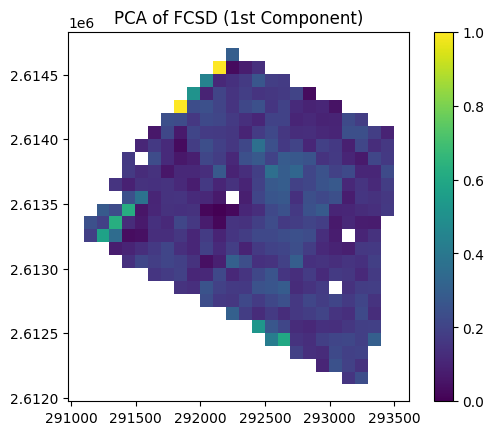

In [9]:
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = 'h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\alpha_diversity_filtered2.shp'
gdf = gpd.read_file(shapefile_path)

# Extract the FCSD values
fcsd_columns = ['fcsd_ir', 'fcsd_red_e', 'fcsd_red', 'fcsd_green']
fcsd_values = gdf[fcsd_columns].values

# Standardize the FCSD values before applying PCA
scaler = StandardScaler()
fcsd_scaled = scaler.fit_transform(fcsd_values)

# Perform PCA
pca = PCA(n_components=1)  # Adjust the number of components as needed
gdf['PC1'] = pca.fit_transform(fcsd_scaled)

# Normalize PC1 for better visualization
gdf['PC1_normalized'] = (gdf['PC1'] - gdf['PC1'].min()) / (gdf['PC1'].max() - gdf['PC1'].min())

# Save the updated GeoDataFrame with PC1 as a shapefile
# gdf.to_file('h:\\Yehmh\\DNDF\\202404_DNDF\\spectral_diversity\\pca_alpha_diversity.shp')

# Plot the grid using PC1 as color
gdf.plot(column='PC1_normalized', cmap='viridis', legend=True)
plt.title('PCA of FCSD (1st Component)')
plt.show()
